### Quality trim reads at windows with PHRED score < 30 with Trimmomatic
#### Install Trimmomatic:  
`conda install -c bioconda trimmomatic`
  
#### Run Trimmomatic:

In [1]:
from Bio import SeqIO
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!mkdir trimmed_reads
!mkdir trimmed_reads_singletons
!mkdir trimmomatic_stats


with open('trimmomatic_stats/trimmomatic_log.txt','wt') as log:
    for R1 in glob.glob('concat/*_R1_*.fastq'):
        smpl = R1.split('/')[-1].split('_')[0]
        R2 = R1.replace('_R1_','_R2_')
        f_paired = R1.replace('concat','trimmed_reads')
        r_paired = R2.replace('concat','trimmed_reads')
        f_single = R1.replace('concat','trimmed_reads_singletons')
        r_single= R2.replace('concat','trimmed_reads_singletons')

        lines = !trimmomatic PE -phred33 \
                    $R1 \
                    $R2 \
                    $f_paired \
                    $f_single \
                    $r_paired \
                    $r_single \
                    ILLUMINACLIP:None:2:30:10 \
                    LEADING:3 \
                    TRAILING:3 \
                    SLIDINGWINDOW:4:15 \
                    MINLEN:150
        for l in lines:
            log.write(l+'\n')

#### Summary plots

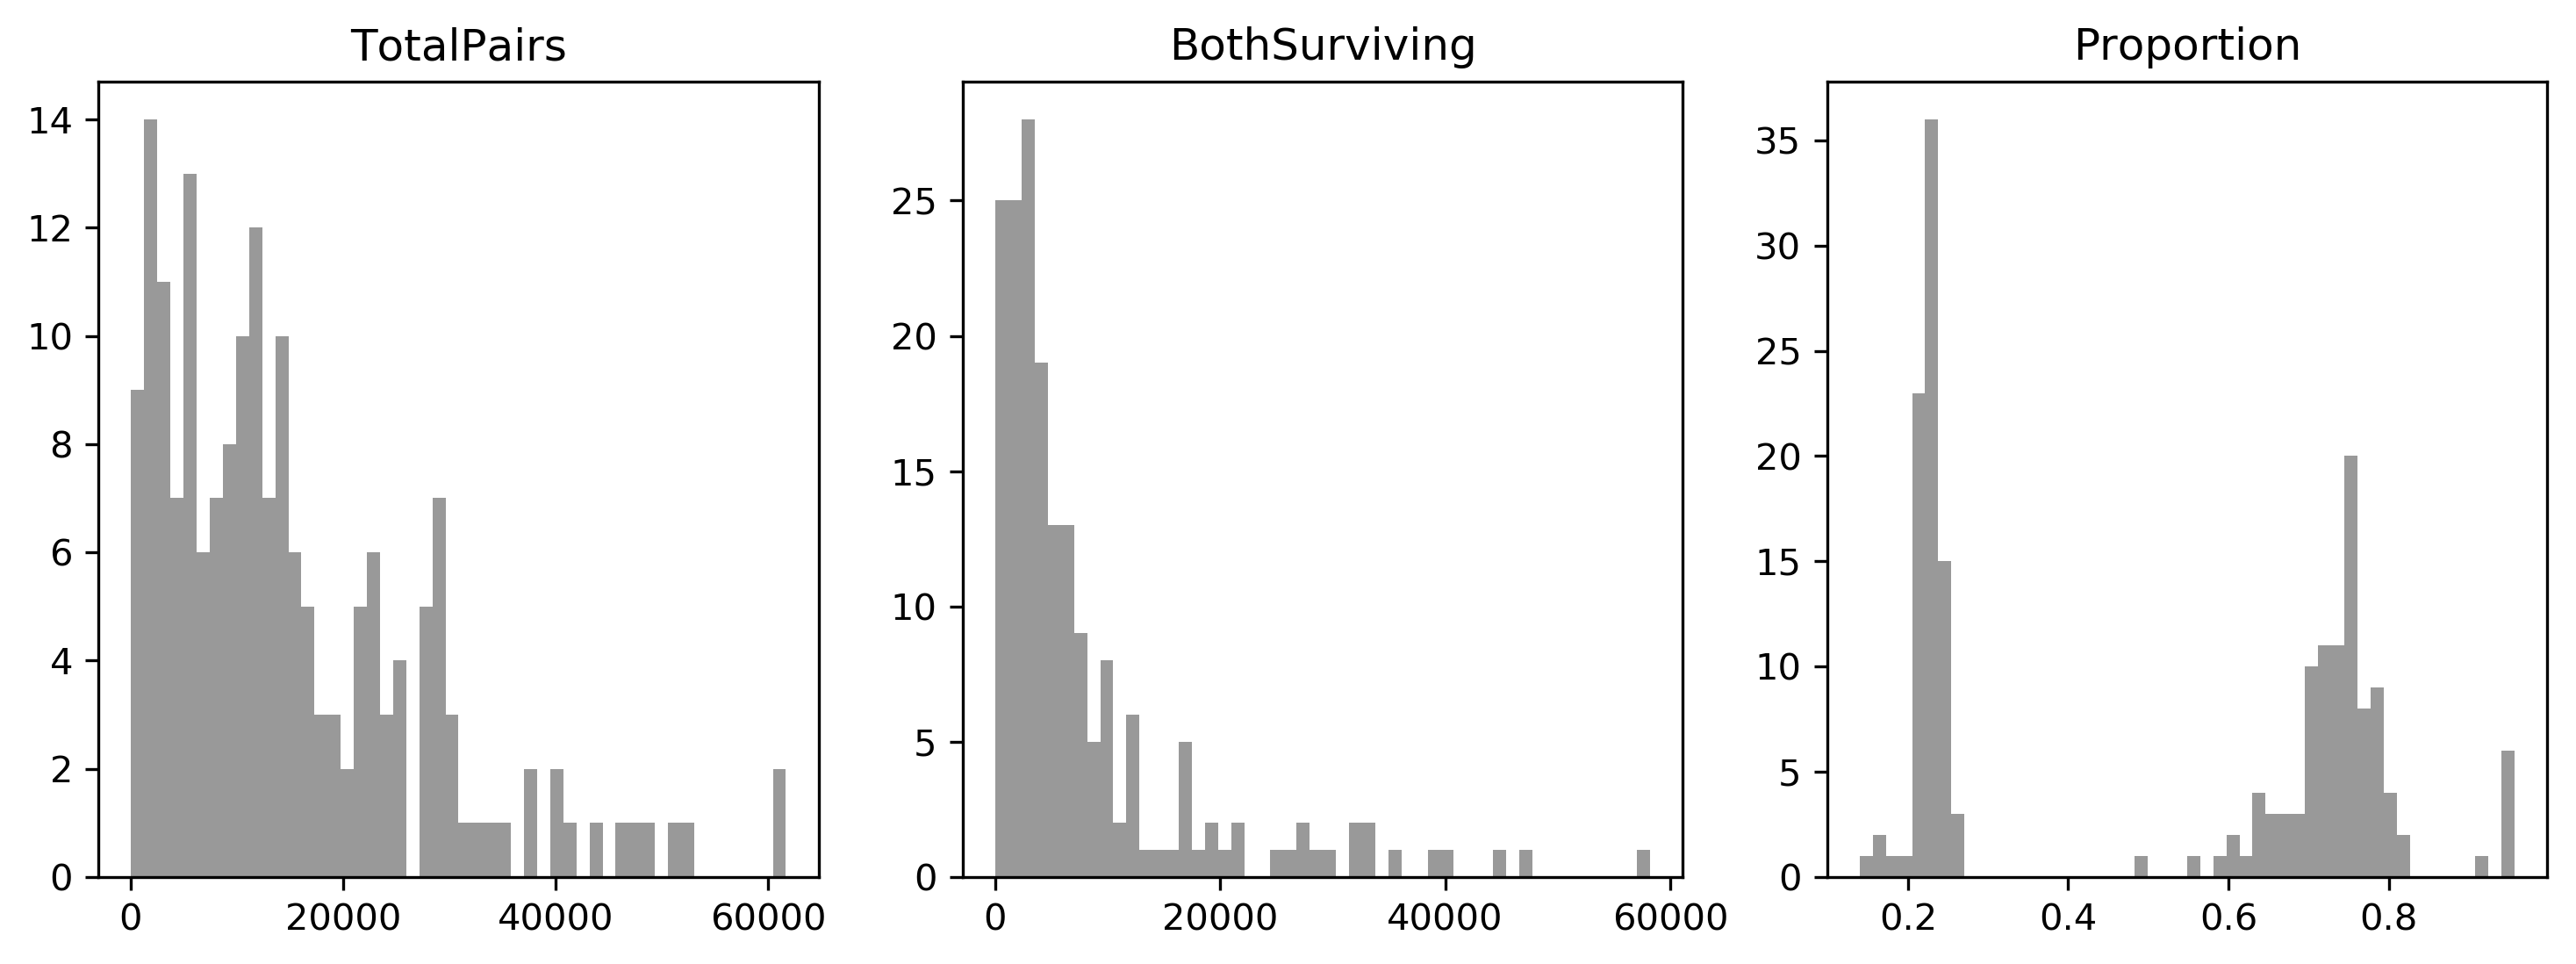

In [21]:
logs = open('trimmomatic_stats/trimmomatic_log.txt','r').read().split('TrimmomaticPE: Started with arguments:')[1:]

df = pd.DataFrame(columns = ['TotalPairs','BothSurviving'])

for l in logs:
    lines = l.splitlines()[1:]
    smpl = lines[0].split()[2].split('/')[-1].split('_')[0]
    try:
        total = int(lines[-3].split(' ')[3])
        survive = int(lines[-3].split(' ')[6])
    except:
        total = int(lines[-2].split(' ')[3])
        survive = int(lines[-2].split(' ')[6])
    df.loc[smpl] = [total,survive]
    
df['Proportion'] = df.BothSurviving / df.TotalPairs
df.to_csv('trimmomatic_stats/summary.tsv',sep='\t')

fig, axes = plt.subplots(ncols=3,figsize=(12,4),dpi=300)

ax = axes[0]
sns.distplot(df.loc[df.TotalPairs < 65000].TotalPairs.tolist(),ax=ax,color='black',kde=False,bins=50)
ax.set_title('TotalPairs')
ax = axes[1]
sns.distplot(df.loc[df.TotalPairs < 65000].BothSurviving.tolist(),ax=ax,color='black',kde=False,bins=50)
ax.set_title('BothSurviving')
ax = axes[2]
sns.distplot(df.loc[df.TotalPairs < 65000].Proportion.tolist(), ax=ax,color='black',kde=False,bins=50)
a = ax.set_title('Proportion')

#### Filter files
If there are less than 4000 read pairs, trash sample. If there are over 40,000 read pairs, downsample to 40,000.

In [10]:
for R1 in glob.glob('trimmed_reads/*_R1_001.fastq'):
    R2 = R1.replace('_R1_','_R2_')
    if len(open(R1,'r').readlines()) < 4000:
        !rm $R1
        !rm $R2
    elif len(open(R1,'r').readlines()) > 40000:
        records = list(SeqIO.parse(R1,'fastq'))
        SeqIO.write(records[:10000],R1,'fastq')
        records = list(SeqIO.parse(R2,'fastq'))
        SeqIO.write(records[:10000],R2,'fastq')